### Steps:
- Adapt both normal and noisy logs based on given threshold and adaptation actions
- Encode traces and save an encoded 

In [64]:
import time

# get the start time
start_time_code = time.process_time()

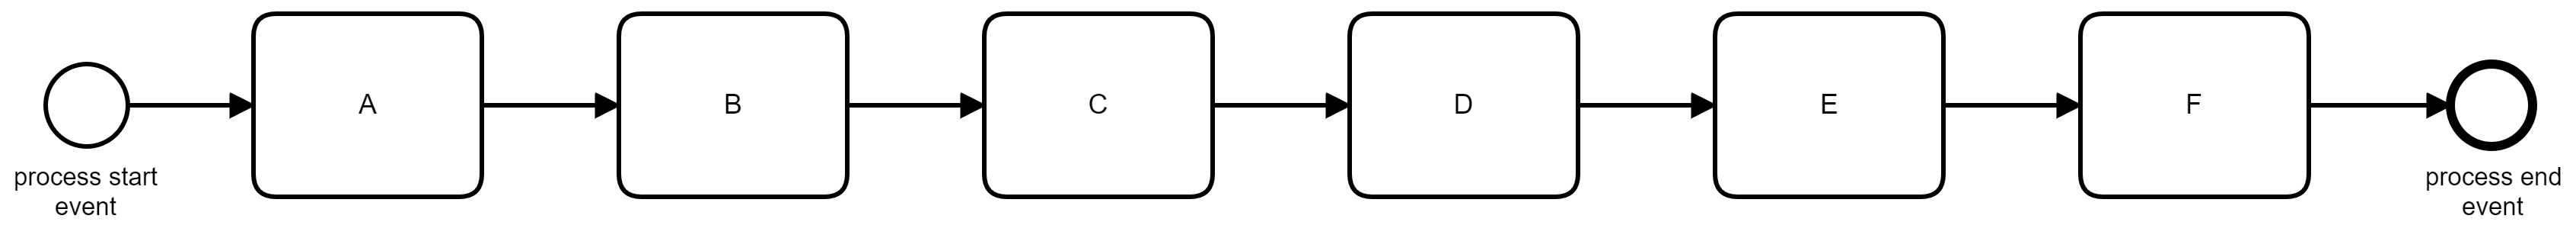

In [65]:
from IPython.display import Image

SKIP_ACTIVITY, INSERT_ACTIVITY = 'skip-activity', 'insert-activity'
ADAPTATIONS = [SKIP_ACTIVITY, INSERT_ACTIVITY]

ADAPTATION_TYPE = SKIP_ACTIVITY
LOGS_DIR = '../logs/simulation-models/'
LOG_NAME = 'sample_sequence_simulation_logs'
LOG_PATH = LOGS_DIR + LOG_NAME + '.xes'
TRANSFORMED_LOG_PATH = LOGS_DIR + LOG_NAME + '_transformed.xes'

raw_data_file_name = LOGS_DIR + LOG_NAME + '_adapted_multi.csv'
noisy_data_file_name = LOGS_DIR + LOG_NAME + '_adapted_noisy_multi.csv'

raw_data_object_file_path = LOGS_DIR + LOG_NAME + '_event_logs_patterned.pickle'
noisy_data_object_file_path = LOGS_DIR + LOG_NAME + '_event_logs_noisy.pickle'

Image(filename=LOGS_DIR + 'sample_sequence.png') 

In [66]:
def read_obj_from_file(file_path):
    import pickle
    file_to_read = open(file_path, "rb")
    loaded_object = pickle.load(file_to_read)
    file_to_read.close()
    return loaded_object

event_logs_patterned = read_obj_from_file(raw_data_object_file_path)
noisy_logs = read_obj_from_file(noisy_data_object_file_path)


### Adapt traces using the time threshold

In [67]:
def shift_consecutive_events(trace_events, event_index, time_shift):
    #shift all timestamps after this event
    for ev_index, ev in enumerate(trace_events):
        if ev_index > event_index:
            ev['start_time'] += time_shift
            ev['end_time'] += time_shift

def adaptation_action_skip(trace, parameters):
    # this implementation skips the skippable activity in a given trace
    for event_index, event in enumerate(trace['events']):
        if event['name'] == parameters['skippable_activity_name']:
            skippable_activity_duration = event['end_time'] - event['start_time']
                    #update consequent timestamps
            time_shift = skippable_activity_duration
            shift_consecutive_events(trace, event_index, time_shift)
                    #remove activity from the events
            trace['events'].pop(event_index)

def adaptation_action_insert(trace, parameters):
    # this implementation inserts the insertable activity in a given trace based after a given point
    for event_index, event in enumerate(trace['events']):
        
        if event['name'] == parameters['insert_after']:
            # add insertable activity after it

            time_shift = parameters['insertable_activity_duration']
            shift_consecutive_events(trace, event_index, time_shift)

            activity = dict()
            activity['name'] = parameters['insertable_activity_name']
            activity['start_time'] = event['end_time']
            activity['end_time'] = event['end_time'] + parameters['insertable_activity_duration']
            activity['resource'] = parameters['insertable_activity_resource']

            trace['events'].insert(event_index + 1, activity)

def take_action(trace, parameters):

    trace_events = trace['events']
    trace_cycle_time = trace_events[-1]['end_time'] - trace_events[0]['start_time']

    # set adapted flag
    trace['adapted'] = True
    
    if trace_cycle_time > parameters['cycle_time_threshold']:
        adaptation_action_skip(trace, parameters)
    elif trace_cycle_time < parameters['cycle_time_min']:
        adaptation_action_insert(trace, parameters)
    else:
        # no adaptation action required
        trace['adapted'] = False

    return trace['adapted']


def adapt_logs(logs, parameters):

    num_traces = len(logs)
    num_adapted_traces = 0
    
    for trace in logs:
        adapted = take_action(trace, parameters)
        # do the adaptation if the threshold is violated 
        if adapted:
            num_adapted_traces += 1

    print('Adapted traces percentage:', 100 * num_adapted_traces/num_traces)
    return logs



from datetime import timedelta

parameters = dict()

parameters['cycle_time_threshold'] = timedelta(hours=4, minutes=10)
parameters['skippable_activity_name'] = 'E'

parameters['cycle_time_min'] = timedelta(hours=3, minutes=15)
parameters['insertable_activity_name'] = 'I'
parameters['insertable_activity_duration'] = timedelta(minutes=30)
parameters['insertable_activity_resource'] = 'Inserted_Activity_resource'
parameters['insert_after'] = 'F'

event_logs_adapted = adapt_logs(event_logs_patterned, parameters)
noisy_logs_adapted = adapt_logs(noisy_logs, parameters)

Adapted traces percentage: 45.8
Adapted traces percentage: 47.0


In [68]:
def logs_to_dict(logs):

    from datetime import timedelta
    all_events = []

    for trace in logs:
        
        trace_events = trace['events']

        for event_index, event in enumerate(trace_events):
            event_dict = {'trace_id':trace['trace_id']}
            event_dict['event_name'] = event['name']
            event_dict['start_time'] = event['start_time']
            event_dict['start_weekday'] = event['start_time'].weekday()
            event_dict['end_time'] = event['end_time']
            event_dict['duration'] = (event['end_time'] - event['start_time']) / timedelta(minutes=1)
            event_dict['resource'] = 'NA' if event['resource'] == None else event['resource']
            event_dict['adapted'] = trace['adapted']
            all_events.append(event_dict)
    
    return all_events

### store logs to csv files (adapted.csv and adapted_noisy.csv)

In [69]:
def write_to_file_csv(file_name, data_dic):
    import csv

    with open(file_name, mode='w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = list(data_dic[0].keys()))
        writer.writeheader()
        writer.writerows(data_dic)

raw_data = logs_to_dict(event_logs_adapted)
write_to_file_csv(raw_data_file_name, raw_data)

noisy_data = logs_to_dict(noisy_logs_adapted)
write_to_file_csv(noisy_data_file_name, noisy_data)

### Encode data (from events of traces to data rows, each trace -> one row)

In [70]:
def encode_data(input_csv_file_name, output_csv_file_name):
    import pandas as pd
    import pm4py
    from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
    from datetime import timedelta

    print('Encoding logs to:', output_csv_file_name)

    dataframe = pd.read_csv(input_csv_file_name, sep=',')
    dataframe = pm4py.format_dataframe(dataframe, case_id='trace_id', activity_key='event_name', 
                                        start_timestamp_key='start_time', timestamp_key='end_time')
    event_log = pm4py.convert_to_event_log(dataframe)

    data, feature_names = log_to_features.apply(event_log)

    df = pd.DataFrame(data, columns=feature_names)
    
    cycle_times = []

    grouped_traces = dataframe.groupby(by='trace_id')
    for name, group in grouped_traces:
        trace_cycle_time = (group.iloc[-1]['end_time'] - group.iloc[0]['start_time']) / timedelta(minutes=1)
        cycle_times.append(trace_cycle_time)

    # traces_data = pd.concat([dataframe.groupby(by='trace_id').head(1)['start_time'].sort_values(ascending=True).reset_index(drop=True), dataframe.groupby(by='trace_id').tail(1)['end_time'].sort_values(ascending=True).reset_index(drop=True)], axis=1, keys=['start', 'end'])
    # traces_data['duration'] = traces_data['end'] - traces_data['start']
    
    df['trace:cycle_time'] = cycle_times
    df['adapted'] = dataframe.groupby(by='trace_id')['adapted'].min()
    df.index.name = 'trace_id'

    df.to_csv(output_csv_file_name)

raw_data_encoded_output_file_name = LOGS_DIR + LOG_NAME + '_multi_adapted_encoded.csv'
noisy_data_encoded_output_file_name = LOGS_DIR + LOG_NAME + '_multi_adapted_noisy_encoded.csv'

encode_data(raw_data_file_name, raw_data_encoded_output_file_name)
encode_data(noisy_data_file_name, noisy_data_encoded_output_file_name)
print('Encoding done!')

Encoding logs to: ../logs/simulation-models/sample_sequence_simulation_logs_multi_adapted_encoded.csv
Encoding logs to: ../logs/simulation-models/sample_sequence_simulation_logs_multi_adapted_noisy_encoded.csv
Encoding done!


### Validation

In [71]:
def measure_log_fitness_percentage(logs):
    import pm4py

    net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(logs)
    pm4py.view_petri_net(net, initial_marking, final_marking)

    replayed_traces = pm4py.conformance_diagnostics_token_based_replay(logs, net, initial_marking, final_marking)

    num_traces_in_logs = len(logs)
    num_traces_fit = 0

    for replayed_trace in replayed_traces:
        if replayed_trace['trace_is_fit'] == True:
            num_traces_fit += 1
    
    return (num_traces_fit * 100) / num_traces_in_logs

parsing log, completed traces :: 100%|██████████| 1000/1000 [00:01<00:00, 508.30it/s]


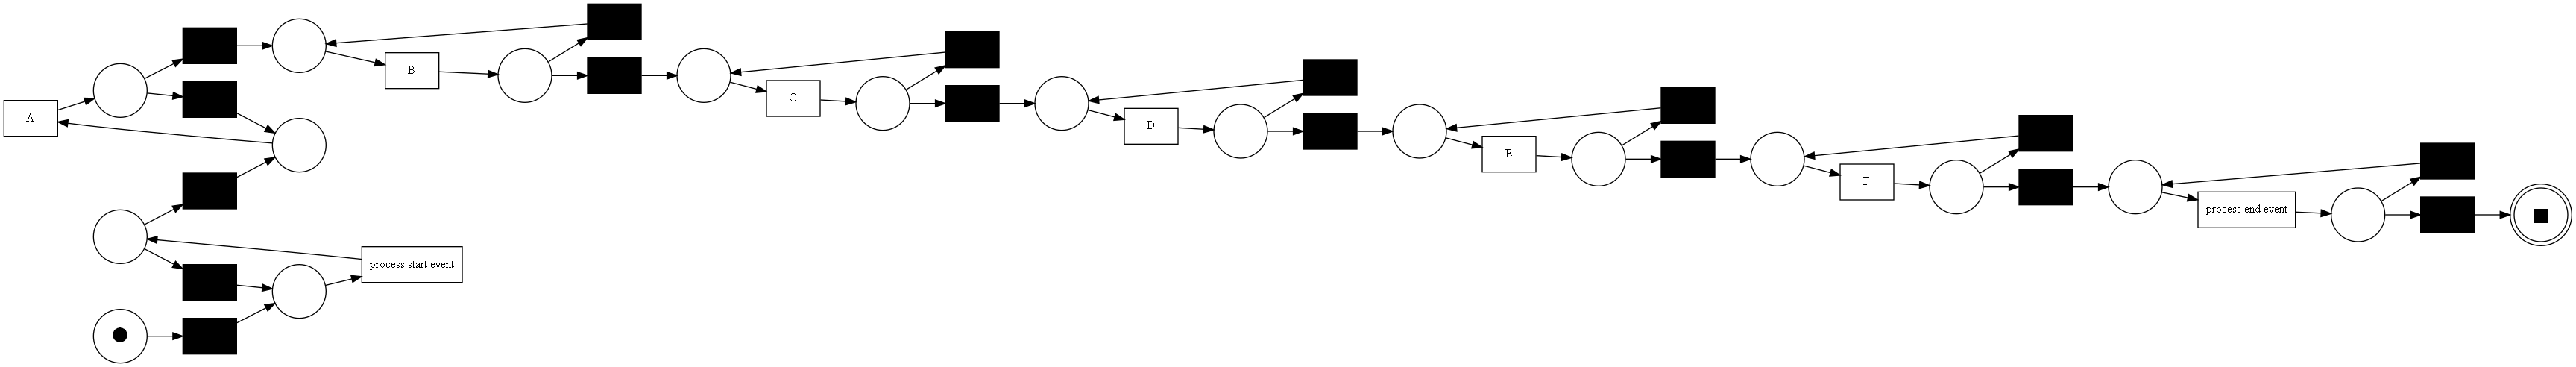

Transformed logs fitness percentage: 100.0


In [72]:
import pm4py

transformed_logs = pm4py.read_xes(TRANSFORMED_LOG_PATH)
transformed_logs_fitness_percentage = measure_log_fitness_percentage(transformed_logs)
print('Transformed logs fitness percentage:', transformed_logs_fitness_percentage)

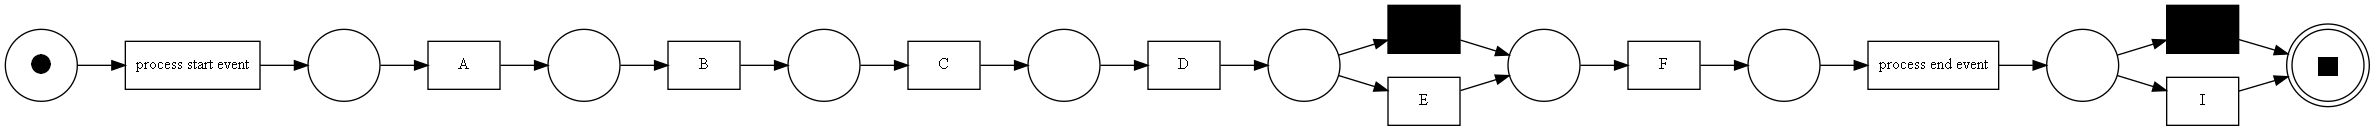

replaying log with TBR, completed variants :: 100%|██████████| 3/3 [00:00<00:00, 66.66it/s]


Raw logs fitness percentage: 100.0


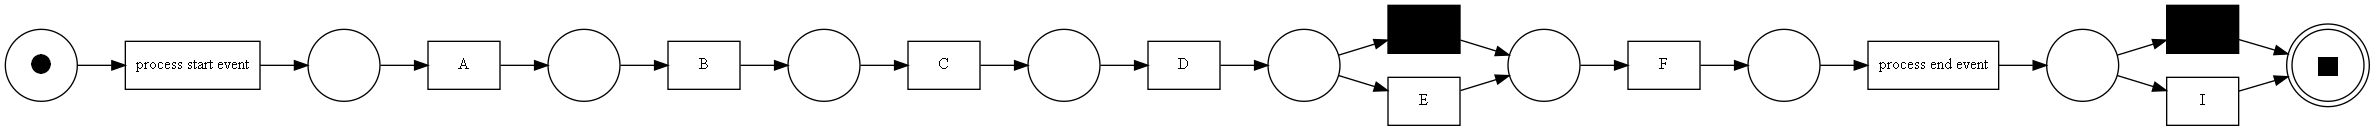

replaying log with TBR, completed variants :: 100%|██████████| 3/3 [00:00<00:00, 69.77it/s]

Noisy logs fitness percentage: 100.0


In [73]:
def measure_fitness_percentage_csv_file(log_path):
    import pandas as pd
    import pm4py

    dataframe = pd.read_csv(log_path)
    dataframe = pm4py.format_dataframe(dataframe, case_id='trace_id', activity_key='event_name', timestamp_key='end_time')
    event_logs = pm4py.convert_to_event_log(dataframe)
    fitness_percentage = measure_log_fitness_percentage(event_logs)
    return fitness_percentage

print('Raw logs fitness percentage:', measure_fitness_percentage_csv_file(raw_data_file_name))
print('Noisy logs fitness percentage:', measure_fitness_percentage_csv_file(noisy_data_file_name))

In [74]:
# get the end time
end_time_code = time.process_time()

# get CPU time
cpu_time = end_time_code - start_time_code
print('CPU Execution time:', cpu_time, 'seconds')

CPU Execution time: 13.90625 seconds
